# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:2')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.937882
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (640, 640)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [ ]:
net = CenterNet(head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes, hw=160))#, l_size_lambda=3)

In [ ]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device(device), lr=1e-3)

In [ ]:
torch.save(net, 'centernet_640.pth')

# Quality

## Postprocessing and visualization

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [18]:
net = torch.load('centernet_640.pth')

In [19]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet18Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [20]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to(device)).cpu()    
    yp = net(x[None].to(device), return_objects=True).cpu()

class 0 heatmap


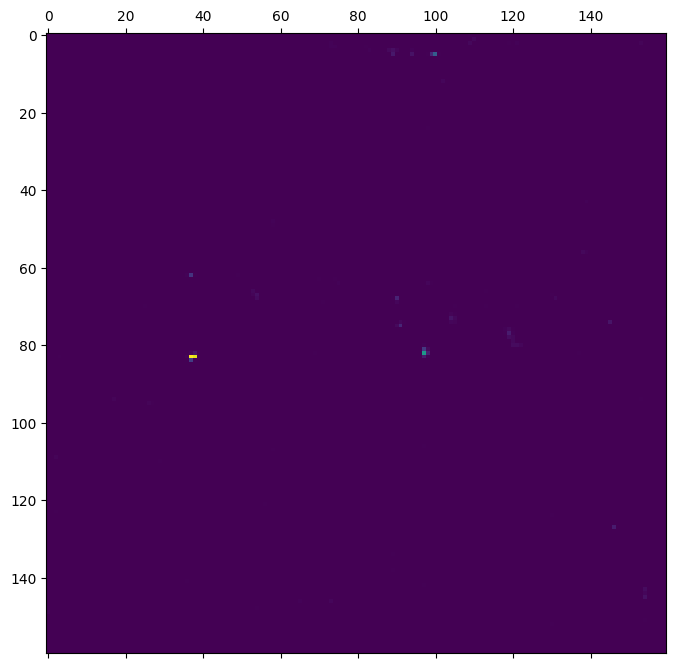

class 1 heatmap


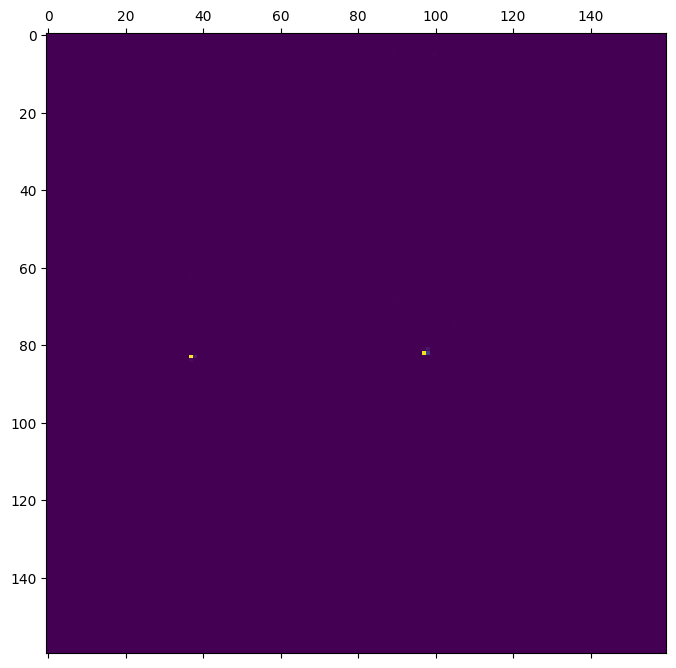

w_heatmap


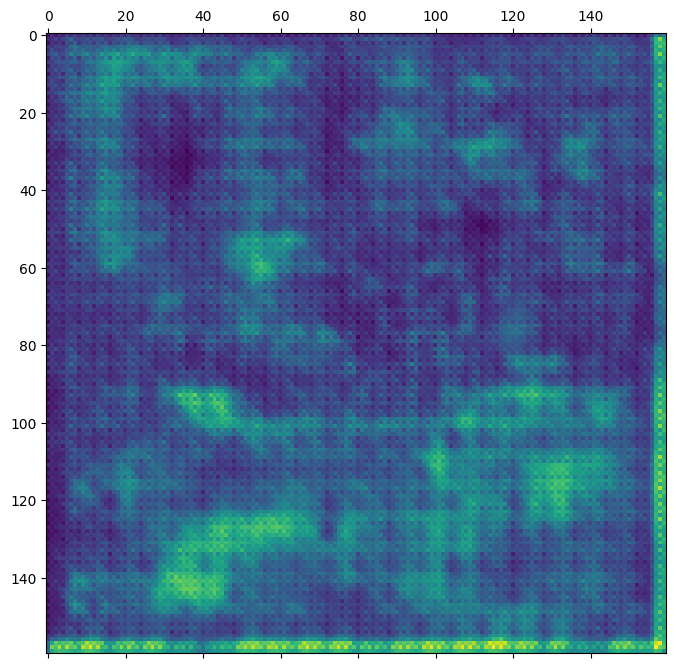

h heatmap


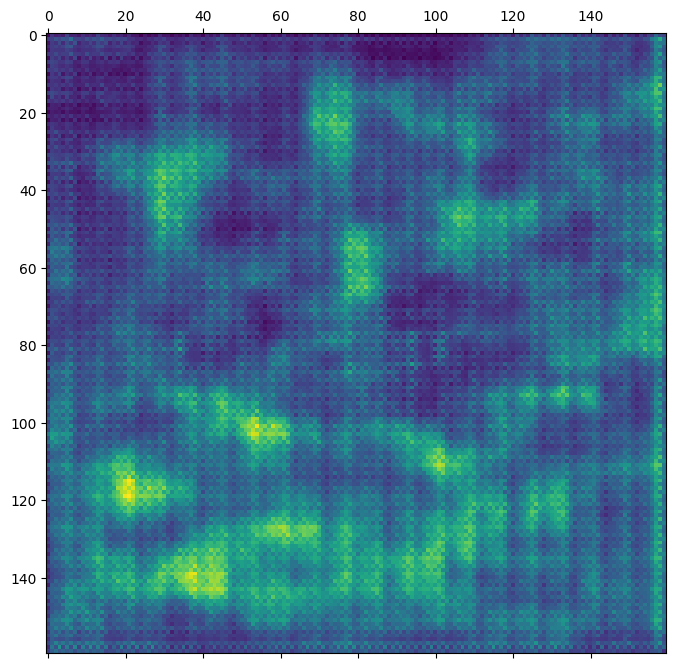

In [21]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [22]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


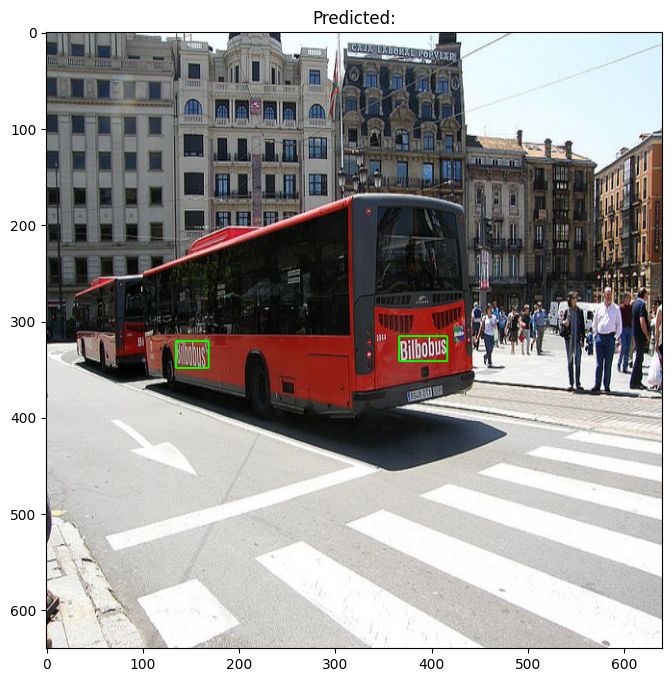

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


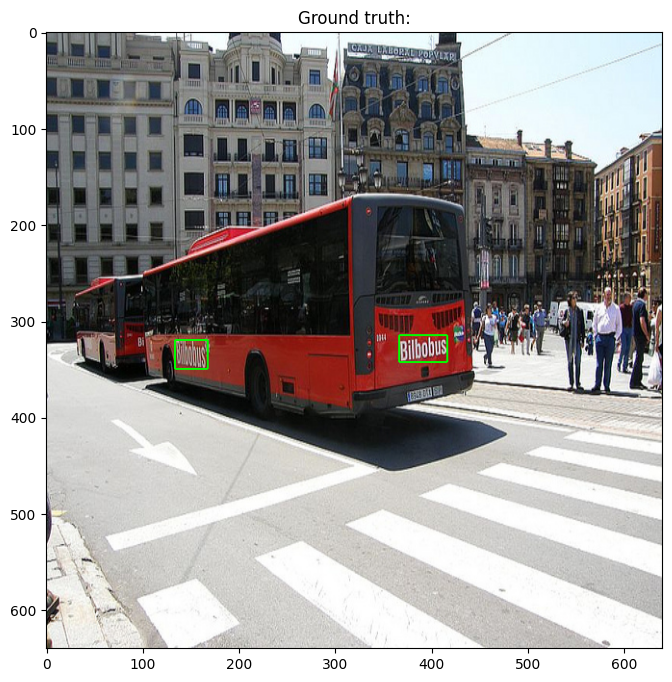

In [23]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [24]:
print(yp[0][:2], y[:2])

tensor([[334.8806, 151.6129,  28.4960,  33.5311,   1.0000,   0.9719],
        [328.9025, 391.8313,  27.2846,  49.8685,   1.0000,   0.9456]]) tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000]])


## Saving to json

In [25]:
#net = torch.load('centernet.pth')

In [26]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:20<00:00, 55.55it/s]


Loading and preparing results...     
DONE (t=0.23s)
Итоговый скор AP на val: 0.3400380319673847


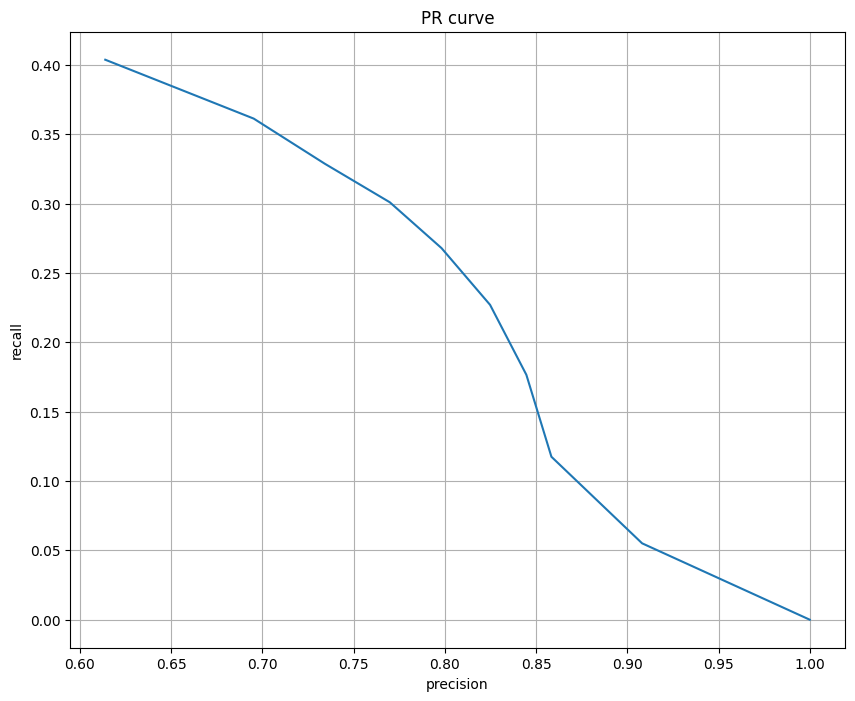

In [27]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [28]:
n_obj

10147

In [ ]:
rec